In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

In [24]:
class ClassifierNN(nn.Module):
    def __init__(self):
        super(ClassifierNN, self).__init__()
        self.first_part = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
        )
        
        self.second_part = nn.Sequential(
            Flatten(),
            nn.Linear(588, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 10),
            nn.Softmax(dim=-1),
        )
        
    def forward(self, x):
        f = self.first_part(x)
        return self.second_part(f)

In [25]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [26]:
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=32)

In [27]:
model = ClassifierNN().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
criterion = nn.NLLLoss()

In [28]:
model.train()

for epoch in range(3):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 250 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    scheduler.step()

Train Epoch: 0 [0/60000 (0%)]	Loss: -0.100209
Train Epoch: 0 [8000/60000 (13%)]	Loss: -0.667313
Train Epoch: 0 [16000/60000 (27%)]	Loss: -0.815450
Train Epoch: 0 [24000/60000 (40%)]	Loss: -0.847382
Train Epoch: 0 [32000/60000 (53%)]	Loss: -0.858953
Train Epoch: 0 [40000/60000 (67%)]	Loss: -0.927778
Train Epoch: 0 [48000/60000 (80%)]	Loss: -0.968807
Train Epoch: 0 [56000/60000 (93%)]	Loss: -0.946956
Train Epoch: 1 [0/60000 (0%)]	Loss: -0.944573
Train Epoch: 1 [8000/60000 (13%)]	Loss: -0.949281
Train Epoch: 1 [16000/60000 (27%)]	Loss: -0.915305
Train Epoch: 1 [24000/60000 (40%)]	Loss: -0.999998
Train Epoch: 1 [32000/60000 (53%)]	Loss: -0.972741
Train Epoch: 1 [40000/60000 (67%)]	Loss: -0.942857
Train Epoch: 1 [48000/60000 (80%)]	Loss: -0.948073
Train Epoch: 1 [56000/60000 (93%)]	Loss: -0.937503
Train Epoch: 2 [0/60000 (0%)]	Loss: -0.999994
Train Epoch: 2 [8000/60000 (13%)]	Loss: -0.968903
Train Epoch: 2 [16000/60000 (27%)]	Loss: -0.945127
Train Epoch: 2 [24000/60000 (40%)]	Loss: -1.00000

----

In [62]:
class AttackerNN(nn.Module):
    def __init__(self):
        super(AttackerNN, self).__init__()
        self.layers = nn.Sequential(
                            nn.ConvTranspose2d(in_channels=12, out_channels=12, kernel_size=3, stride=2, padding=0),
                            nn.LeakyReLU(),
                            nn.ConvTranspose2d(in_channels=12, out_channels=6, kernel_size=3, stride=2, padding=2),
                            nn.LeakyReLU(),
                            nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=4, stride=1, padding=1),
                            nn.LeakyReLU(),
                         )
        
    def forward(self, x):
        return self.layers(x)

In [63]:
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=16)

In [64]:
attacker_model = AttackerNN().cuda()
optimiser = optim.Adam(attacker_model.parameters(), lr=1e-3)

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.cuda(), target.cuda()

        optimiser.zero_grad()

        target_outputs = model.first_part(data)

        attack_outputs = attacker_model(target_outputs)

        loss = ((data - attack_outputs)**2).mean()

        loss.backward()
        optimiser.step()

    if epoch % 1 == 0:
        print('Attacker train epoch: {}\tLoss: {:.6f}'.format(epoch, loss.item()))

Attacker train epoch: 0	Loss: 0.229161
Attacker train epoch: 1	Loss: 0.159094
Attacker train epoch: 2	Loss: 0.092164
Attacker train epoch: 3	Loss: 0.087424
Attacker train epoch: 4	Loss: 0.085787
Attacker train epoch: 5	Loss: 0.083584
Attacker train epoch: 6	Loss: 0.079702
Attacker train epoch: 7	Loss: 0.075861
Attacker train epoch: 8	Loss: 0.074961
Attacker train epoch: 9	Loss: 0.073539


---

tensor(3)


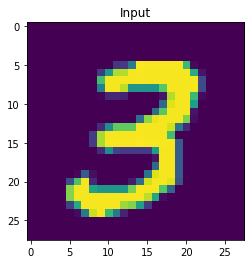

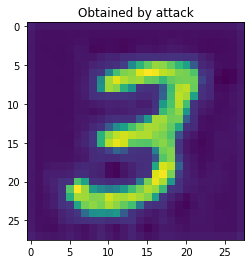

In [70]:
INDEX=7

for data, _ in train_loader:
    data = data.cuda()

    print(_[INDEX])
    
    target_outputs = model.first_part(data)
    attack_outputs = attacker_model(target_outputs)

    im_input = data[INDEX].detach().cpu().numpy()[0]
    im_attack = attack_outputs[INDEX].view(28,28).detach().cpu().numpy()
    
    plt.imshow(im_input)
    plt.title('Input')
    plt.show()
    
    plt.imshow(im_attack)
    plt.title('Obtained by attack')
    plt.show()
    
    break